# Introduction

MIA (Mouse Image Analyzer) is an application designed to take in a video of a mouse and spit out data about time it spends in certain marked areas of the video known as *key cells*. This notebook will discuss the basic concepts behind how MIA works as well as a watered-down walk through an example using a custom 25-frame drawing.

### Logic

The logic is as follows:
1. Take in a video and an FPS in as input
2. Split the video into individual frames
3. Draw a grid over each frame
4. Identify *key cells* which will be the area we want to focus on observing
5. Block all non-*key cells* out and output these new frames
6. Observe *pixel values* in those cells and detect changes
7. Count each frame with a significant *pixel value* (indicates mouse presence)
8. Tally these frames and convert the data into time (seconds)
9. Output data
10. Goal achieved

### Output

This program notebook will output:
* A CSV file listing the raw number of frames observed, the number of significant appearances tallied, and and a tally of time data (in seconds)

The CSV should list this information frame by frame, as shown in this example:

[![observation-example.png](https://i.postimg.cc/L5Fg0Y8X/observation-example.png)](https://postimg.cc/0MZNzNmR)

# Features

### This notebook

This notebook can:
* Take in individual frames and FPS as input
* Trim frames to show the *key cell* in the center (only cell 5)
* Output aforementioned CSV file

### Current MIA

The current, complete version of MIA can:
* Do nothing as it hasn't been made yet

### Future MIA

Planned features for the complete version of MIA:
* Take in a video file and FPS as input
* Split video files into individual frames
* Draw gridlines over frames
* Output modified individual frames (3x3 gridlines)
* Let the user select which of the 9 cells are *key cells*
* Output the modified individual frames (show only *key cells*)
* Include a command-line interface for inputting values and running program
* Include a Graphical User Interface for selecting a video file, inputting FPS, &c.
* Allow users to enter a custom grid size (larger grids are more accurate as cells are smaller)
* Display a preview of the modified frames (gridlines)
* Allow users to click on cells in the preview to mark *key cells*
* Use threshold values to better separate the mouse from the background
* Allow users to input custom threshold values with a live preview that also outputs how many pixels the currently recognized subject is
* Allow users to input precise vertical and horizontal shift for the gridlines (and trimming)
* Support odd *key cell* placements (non-touching cells)
* Include a subscript that measures your mouse using a single frame where the entirety of the mouse is in one cell, allows you to change the threshold and see a live preview of how it measures your mouse, outputs in real time the recognized size, and from there allows you to determine a custom majority (default is 51% of subject size)


You can find MIA <a href="https://github.com/h-ckett/MIA">on GitHub here</a>.

# Example

### Imports and Global vars

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, data
from skimage.io import imread
import matplotlib.cm as cm
import csv

FPS = 5                             # This will be the FPS we work with for this example

### Load up and plot an example frame

In this example we have a single *key cell*, which is the center cell. We are tracking a three-pixel long organism which appears pure black in contrast to the white background. The 25-frame set of images we'll be using throughout the rest of the example is available <a href="https://github.com/h-ckett/MIA/tree/master/example">here</a>.

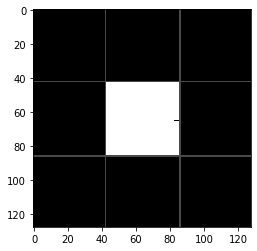

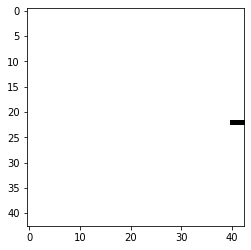

In [33]:
# Create a variable for our frame, which already has its gridlines and non-key cell(s) masked
frame_gridlined = "frame1.png"

# Read it in as grayscale
untrimmed = imread(frame_gridlined, as_gray = True)

# Plot it once
plt.imshow(untrimmed, cmap = cm.gray)
plt.show()

# Trim to only show the key cell(s)
trimmed = untrimmed[43:86, 43:86]

# Plot the trimmed image
plt.imshow(trimmed, cmap = cm.gray)
plt.show()

When tallying frames that contain our subject, we want to ensure that the majority of the subject is in the *key cell* before counting it. After all, if just the tip of your mouse's tail is in the *key cell*, does it really count? When applying this to mice, we can grab a frame that wholly contains the mouse, measure its size (in px), and take about half that amount as our *majority* variable to be safe. Whenever that much of the mouse is within a *key cell*, that frame will be tallied.

Since our "subject" in this example is three pixels in size, we want to make sure that at least two pixels of it are visible in the *key cell* before applying that frame to our tally. Thus, our *majority* == 2.

### Check the frame for the subject
#### Visualing what the program is doing

Moving forward in our example, we'll now take the *trimmed* image we plotted above and check to see if our subject is inside the *key cell(s)* or not.

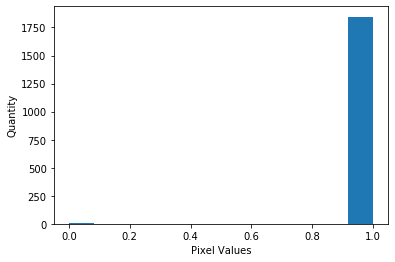

In [34]:
# Histogram of the trimmed image's pixel quantities
plt.hist(trimmed.flat, bins = 'auto')
plt.xlabel("Pixel Values")
plt.ylabel("Quantity")
plt.show()

We can tell from the histogram that there are quite a few white pixels in our image -- that's what the large bar on the right represents. But what you may not have noticed is the very short bar on the left; that's our subject appearing, all three pixels of it. Let's zoom in to get a better look.

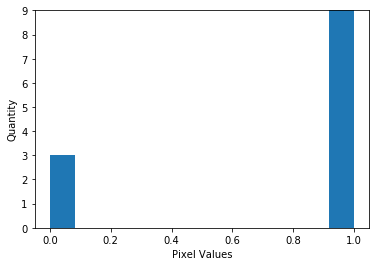

In [35]:
# Histogram of the trimmed image's pixel quantities, focusing on a very low quantity to illustrate our three-pixel subject
plt.hist(trimmed.flat, bins = 'auto')
plt.xlabel("Pixel Values")
plt.ylabel("Quantity")
plt.ylim([0, 9])     # This line is where we limit the y-axis
plt.show()

Now that we've tweaked our histogram a bit, it's very clear to see the presence of our subject. Remember, we only want to tally a frame if we see the desired *majority* of our subject. For the purposes of our example, our *majority* is two; seeing as there's three pixels showing here, we can count this frame and add it to our tally with confidence.

#### Code

So, how is the program going to tackle this? Well, just like we did, it's going to need to check for the presence of pixels that represent our subject. It'll load each frame one by one and, as it loads them, check through every pixel and count how many meet a certain threshold. For this example there's only two colors, so our threshold is easily determined: for an image of a mouse, however, we'll have to play around with the threshold until we get the result we want. After this tally (called *localCount* in the script below), we can check if it meets our *majority*. If it does, we add it to an overall tally (called *tally* in the script below) and begin to populate our CSV.

In [36]:
# Loop to tally total number of major appearances of subject
majority = 2         # We're looking for 2 pixels or greater
frameCount = 25      # We have 25 frames to look through
fileNames = []       # Set up our file names list
fileNames.append('') # Initialize
tally = []           # Set up our tally score
tally.append(0)      # Initialize
totalTime = []       # Set up our time counter var
totalTime.append(0)  # Initialize

for i in range(frameCount):
    # Import frames
    frame_gridlined = "frame%s.png" %str(i + 1)                    # Image name changes per iteration; folder location varies
    untrimmed = imread(frame_gridlined, as_gray = True)            # Load it in grayscale, as we did when making our plots
    trimmed = untrimmed[43:86, 43:86]                              # Trim it to only show key cell(s)
    
    localCount = trimmed < 0.1                                     # Make a local counter that sees if each pixel is black
    localCount = np.sum(localCount)                                # Take the sum of those results
    
    # We now have the data on how many px of our subject is in a particular frame (localCount)
    if(localCount >= majority):                                    # If the majority of the subject is in the frame...
        tally.append(tally[i] + 1)                                 # ... we add to our tally
    else:                                                          # If there wasn't significant presence...
        tally.append(tally[i])                                     # ... our tally stays the same
    totalTime.append(totalTime[i] + (1 / FPS))                     # Add to our time regardless of result
    fileNames.append(frame_gridlined)                              # Record the filename

Let's take a peek at what we've just created by printing some information:

In [37]:
print(tally)
print(tally[len(tally) - 1])

print([float("%.2f" % x) for x in totalTime])
print(totalTime[len(totalTime) - 1])

[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 14, 14]
14
[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
5.000000000000002


*Note: since tally and totalTime are tallies we simply print the value at the last index to find the sum.*

Now we can clearly see where frames are in which the subject had a significant presence (met our *majority* case) and where it did not. We can also see the steady lapse of time (each frame lasting 0.2 seconds). Once we plot this it'll be even easier to visualize.

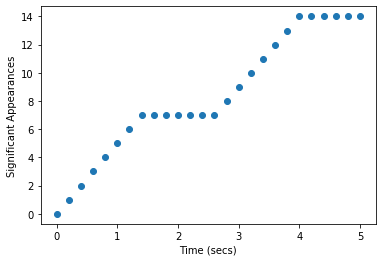

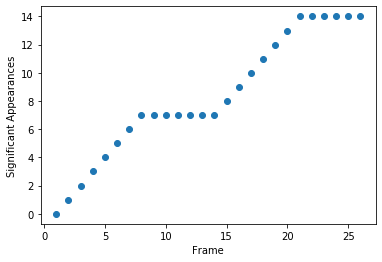

In [38]:
plt.scatter(totalTime, tally)
plt.xlabel("Time (secs)")
plt.ylabel("Significant Appearances")
plt.show()

frames = []
for i in range(26):
    frames.append(i + 1)
    
plt.scatter(frames, tally)
plt.xlabel("Frame")
plt.ylabel("Significant Appearances")
plt.show()

### Exporting the CSV

Our CSV file is going to use a comma (,) as the delimiter, and quotes (") as the quotechar. Let's take a look under the hood at how it will be populated:

In [39]:
print(fileNames)
print(tally)
print([float("%.2f" % x) for x in totalTime])

['', 'frame1.png', 'frame2.png', 'frame3.png', 'frame4.png', 'frame5.png', 'frame6.png', 'frame7.png', 'frame8.png', 'frame9.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png', 'frame14.png', 'frame15.png', 'frame16.png', 'frame17.png', 'frame18.png', 'frame19.png', 'frame20.png', 'frame21.png', 'frame22.png', 'frame23.png', 'frame24.png', 'frame25.png']
[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 14, 14]
[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]


#### Code

In [40]:
# Open up mia_output.csv (will be created if it doesn't exist):
with open('mia_output.csv', mode='w') as mia_output:
    # Define how we want it to operate:
    mia_output = csv.writer(mia_output, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # Make the column titles:
    mia_output.writerow(['filename', 'frame #', 'sig. app. tally', 'time(s)'])
    
    # Now let's populate the CSV with our data
    for i in range(frameCount):
        mia_output.writerow([fileNames[i], i, tally[i], totalTime[i]])

And just like that, we're all done with our example code; there is a CSV file waiting for us to load into another application which we can use to interpret the data. To view the full MIA project online, including this example documentation, the full application, and more, please <a href="https://github.com/h-ckett/MIA">visit my GitHub page</a>.